## Different things tried to solve the problem at hand -
1. Built Random Forest models to get Top 10 variables
2. vif to address multicollinearity issue
3. Built Logistic Regression and XGBoost models as alternatives to Random Forest model
4. Performed oversampling using SMOTE technique
5. Compared the results before and after SMOTE and passed the important variables from Random Forest to a new Logistic Regression model in order to explain their impact on the output variable

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pyodbc
import pandas as pd
import numpy as np
import IPython.display
import os
import sys
import mgrs
import matplotlib.pyplot as plt
import seaborn as sns

In [204]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier)
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb
from sklearn.metrics import log_loss
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
import statsmodels.api as sm

In [4]:
def display_all(df):
    with pd.option_context("display.max_columns", 5000):
        with pd.option_context("display.max_rows", 5000):
            display(df)

In [5]:
path = "C:/Users/ps063n/Desktop/Parag/General/DataScienceProblem/"

In [6]:
df = pd.read_csv(f"{path}data.csv")

In [7]:
display_all(df.head())

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,R
0,1.0,1,0,1,1.0,0,1,1.0,0,1,3.634869,-0.401135,7.298843,2.299257,-0.433587,4.838273,NaN,-1.354651,4.349899,1.068831,-0.995826,2.669044,1.332046,-0.383623,58.203268,2.516582,-0.063320,47.187762,0.050729,-3.556211,0.0
1,0.0,1,1,0,1.0,1,0,1.0,1,0,18.635695,101.291280,1.028453,45.283493,8.032799,0.385358,NaN,4.982916,0.196654,3.589323,3.443913,0.224468,1.732377,4.118886,0.029545,3.469034,61.629681,0.058782,56.154209,11.777673,0.0
2,0.0,1,1,0,1.0,1,0,NaN,1,0,18.391256,182.136756,1.771259,9.259151,146.496257,0.312835,NaN,6.145800,0.591637,2.996391,3.905700,0.625058,4.083644,2.500723,0.285155,31.284113,47.512823,0.101458,35.196478,81.645561,0.0
3,0.0,0,0,0,0.0,0,0,0.0,0,0,-0.198989,-0.065972,1.252370,-0.281176,-0.142626,-6.436934,NaN,-1.922825,-5.415892,-2.144692,-3.110316,-2.885436,-1.545734,-2.284548,-200.012461,-0.046499,-19.956440,NaN,-4.907402,-4.157230,0.0
4,0.0,0,1,0,0.0,1,1,0.0,1,0,-0.660910,6.510449,1.386389,-0.810476,3.679736,1.100299,NaN,0.937796,1.022608,-0.411579,0.989882,0.850447,-0.769063,1.164243,3.792408,-0.003194,10.892589,0.547955,-0.017424,3.889439,0.0


In [8]:
df.shape

(100000, 31)

In [9]:
df.dtypes

V1     float64
V2       int64
V3       int64
V4       int64
V5     float64
V6       int64
V7       int64
V8     float64
V9       int64
V10      int64
V11    float64
V12    float64
V13    float64
V14    float64
V15    float64
V16    float64
V17    float64
V18    float64
V19    float64
V20    float64
V21    float64
V22    float64
V23    float64
V24    float64
V25    float64
V26    float64
V27    float64
V28    float64
V29    float64
V30    float64
R      float64
dtype: object

### checking for missing values

In [10]:
df.isnull().sum()

V1      5188
V2         0
V3         0
V4         0
V5      5139
V6         0
V7         0
V8      5074
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17    64874
V18        0
V19        0
V20        0
V21        0
V22     5046
V23        0
V24        0
V25        0
V26        0
V27        0
V28     5104
V29        0
V30        0
R          0
dtype: int64

### convering target variable to 1/0

In [11]:
df['Target'] = np.where(df['R'] > 0, 1, 0)

In [12]:
df['Target'].value_counts()

0    94465
1     5535
Name: Target, dtype: int64

### rare case events = ~ 6%

In [13]:
5535/94465

0.05859312973058805

### missing value imputation -- "mode" for categorical variable and "median" for continuous variable

In [14]:
for cols in ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']:
    df[cols] = df[cols].fillna(df[cols].mode()[0])

In [15]:
for cols in ['V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
            'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30']:
    df[cols] = df[cols].fillna(df[cols].median())

In [16]:
df.isnull().sum().sum()

0

In [196]:
df.to_csv(f"{path}cleaned_data.csv", index=False)

In [17]:
display_all(df.head())

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,R,Target
0,1.0,1,0,1,1.0,0,1,1.0,0,1,3.634869,-0.401135,7.298843,2.299257,-0.433587,4.838273,-0.288929,-1.354651,4.349899,1.068831,-0.995826,2.669044,1.332046,-0.383623,58.203268,2.516582,-0.063320,47.187762,0.050729,-3.556211,0.0,0
1,0.0,1,1,0,1.0,1,0,1.0,1,0,18.635695,101.291280,1.028453,45.283493,8.032799,0.385358,-0.288929,4.982916,0.196654,3.589323,3.443913,0.224468,1.732377,4.118886,0.029545,3.469034,61.629681,0.058782,56.154209,11.777673,0.0,0
2,0.0,1,1,0,1.0,1,0,0.0,1,0,18.391256,182.136756,1.771259,9.259151,146.496257,0.312835,-0.288929,6.145800,0.591637,2.996391,3.905700,0.625058,4.083644,2.500723,0.285155,31.284113,47.512823,0.101458,35.196478,81.645561,0.0,0
3,0.0,0,0,0,0.0,0,0,0.0,0,0,-0.198989,-0.065972,1.252370,-0.281176,-0.142626,-6.436934,-0.288929,-1.922825,-5.415892,-2.144692,-3.110316,-2.885436,-1.545734,-2.284548,-200.012461,-0.046499,-19.956440,-0.030863,-4.907402,-4.157230,0.0,0
4,0.0,0,1,0,0.0,1,1,0.0,1,0,-0.660910,6.510449,1.386389,-0.810476,3.679736,1.100299,-0.288929,0.937796,1.022608,-0.411579,0.989882,0.850447,-0.769063,1.164243,3.792408,-0.003194,10.892589,0.547955,-0.017424,3.889439,0.0,0


### creating input and output space

In [18]:
x = df.drop(['R', 'Target'], axis=1)
y = df['Target']

### dividing the raw data into train and validation data sets -- stratify sampling on the target variable

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(x,y, stratify = y, test_size = 0.2, random_state = 42)

### random forest classification model (tuned model)

Type II error (False Negative) has more value, because you do not want to lose customer based on your model results

==> recall (sensitivity) should be higher

In [20]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=80, max_features=0.9, criterion='entropy', random_state = 123)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [21]:
preds = rf.predict(X_valid)

In [22]:
accuracy_score(y_valid, preds)

0.9847

In [23]:
confusion_matrix(y_valid, preds)

array([[18772,   121],
       [  185,   922]], dtype=int64)

In [24]:
print(classification_report(y_valid, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18893
           1       0.88      0.83      0.86      1107

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.94      0.91      0.92     20000
weighted avg       0.98      0.98      0.98     20000



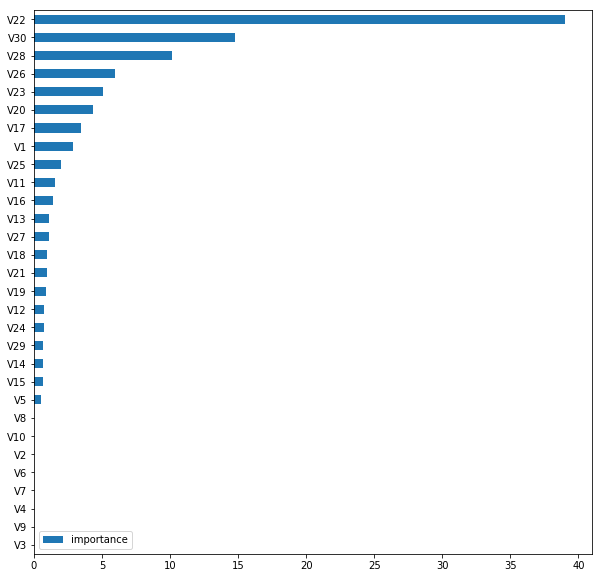

In [25]:
pd.DataFrame(rf.feature_importances_*100, index=x.columns, 
             columns=['importance']).sort_values('importance', ascending=True).plot.barh(figsize = (10,10))

### RF without V28, V22, V30 (poor model)

In [26]:
x_v123 = df.drop(['R', 'Target', 'V22', 'V28', 'V30'], axis=1)
y_v123 = df['Target']

In [28]:
X_train_v123, X_valid_v123, y_train_v123, y_valid_v123 = train_test_split(x_v123, y_v123, stratify = y_v123, test_size = 0.2, random_state = 42)

In [29]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=80, max_features=0.9, criterion='entropy', random_state = 123)
rf.fit(X_train_v123, y_train_v123)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [30]:
preds = rf.predict(X_valid_v123)

In [31]:
accuracy_score(y_valid_v123, preds)

0.9759

In [32]:
confusion_matrix(y_valid_v123, preds)

array([[18767,   126],
       [  356,   751]], dtype=int64)

In [33]:
print(classification_report(y_valid_v123, preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     18893
           1       0.86      0.68      0.76      1107

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.92      0.84      0.87     20000
weighted avg       0.97      0.98      0.97     20000



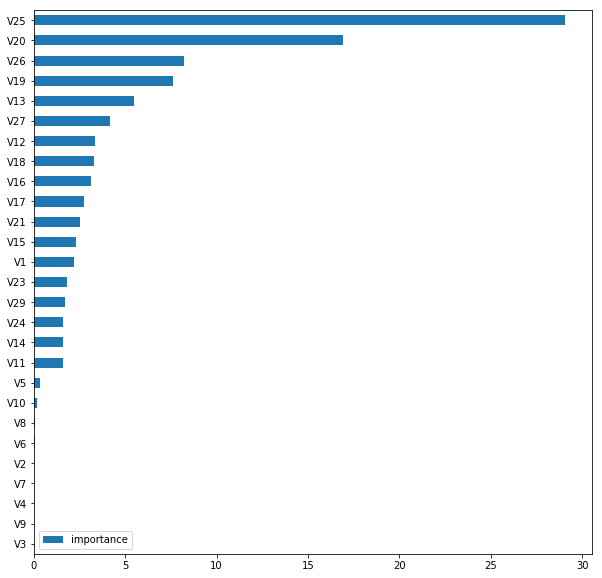

In [34]:
pd.DataFrame(rf.feature_importances_*100, index=x_v123.columns, 
             columns=['importance']).sort_values('importance', ascending=True).plot.barh(figsize = (10,10))

### RF without V22 (poor model)

In [35]:
x_v22 = df.drop(['R', 'Target', 'V22'], axis=1)
y_v22 = df['Target']

In [36]:
X_train_v22, X_valid_v22, y_train_v22, y_valid_v22 = train_test_split(x_v22,y_v22, stratify = y_v22, test_size = 0.2, random_state = 42)

In [37]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=80, max_features=0.9, criterion='entropy', random_state = 123)
rf.fit(X_train_v22, y_train_v22)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [38]:
preds = rf.predict(X_valid_v22)

In [39]:
accuracy_score(y_valid_v22, preds)

0.9794

In [40]:
confusion_matrix(y_valid_v22, preds)

array([[18761,   132],
       [  280,   827]], dtype=int64)

In [41]:
print(classification_report(y_valid_v22, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18893
           1       0.86      0.75      0.80      1107

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.92      0.87      0.89     20000
weighted avg       0.98      0.98      0.98     20000



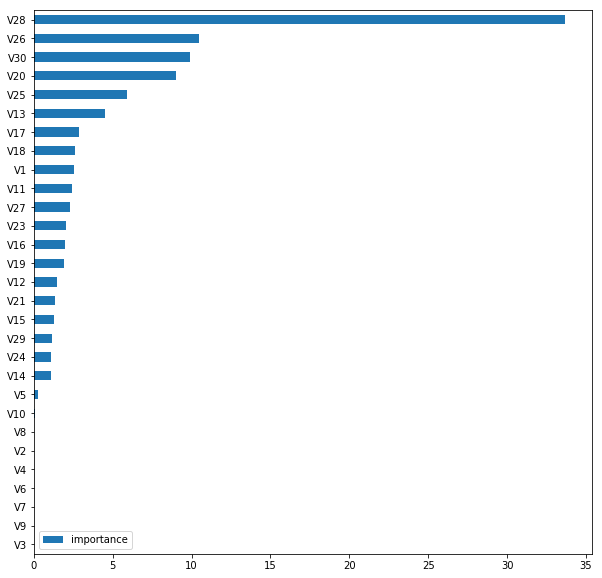

In [42]:
pd.DataFrame(rf.feature_importances_*100, index=x_v22.columns, 
             columns=['importance']).sort_values('importance', ascending=True).plot.barh(figsize = (10,10))

### RF without V30 (poor model)

In [43]:
x_v30 = df.drop(['R', 'Target', 'V30'], axis=1)
y_v30 = df['Target']

In [44]:
X_train_v30, X_valid_v30, y_train_v30, y_valid_v30 = train_test_split(x_v30,y_v30, stratify = y_v30, test_size = 0.2, random_state = 42)

In [45]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=80, max_features=0.9, criterion='entropy', random_state = 123)
rf.fit(X_train_v30, y_train_v30)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [46]:
preds = rf.predict(X_valid_v30)

In [47]:
accuracy_score(y_valid_v30, preds)

0.97875

In [48]:
confusion_matrix(y_valid_v30, preds)

array([[18742,   151],
       [  274,   833]], dtype=int64)

In [49]:
print(classification_report(y_valid_v30, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18893
           1       0.85      0.75      0.80      1107

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.92      0.87      0.89     20000
weighted avg       0.98      0.98      0.98     20000



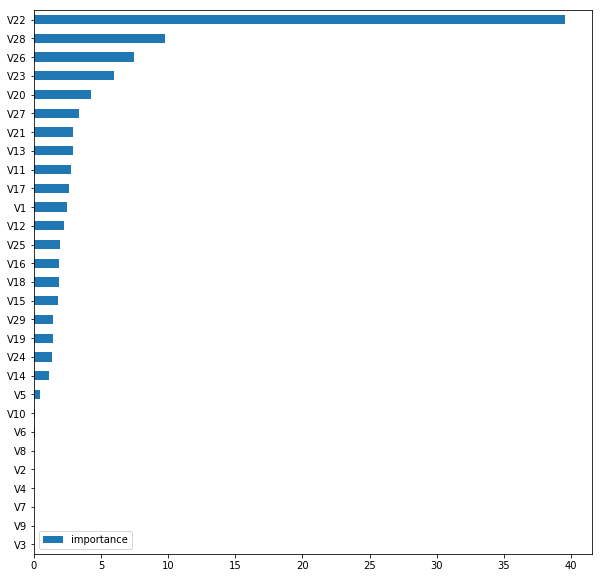

In [50]:
pd.DataFrame(rf.feature_importances_*100, index=x_v30.columns, 
             columns=['importance']).sort_values('importance', ascending=True).plot.barh(figsize = (10,10))

### RF without V28 (Best Model)

In [51]:
x_v28 = df.drop(['R', 'Target', 'V28'], axis=1)
y_v28 = df['Target']

In [54]:
X_train_v28, X_valid_v28, y_train_v28, y_valid_v28 = train_test_split(x_v28, y_v28, stratify = y_v28, test_size = 0.2, random_state = 42)

In [55]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=80, max_features=0.9, criterion='entropy', random_state = 123)
rf.fit(X_train_v28, y_train_v28)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [56]:
preds = rf.predict(X_valid_v28)

In [57]:
accuracy_score(y_valid_v28, preds)

0.9853

In [58]:
confusion_matrix(y_valid_v28, preds)

array([[18780,   113],
       [  181,   926]], dtype=int64)

In [59]:
print(classification_report(y_valid_v28, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18893
           1       0.89      0.84      0.86      1107

   micro avg       0.99      0.99      0.99     20000
   macro avg       0.94      0.92      0.93     20000
weighted avg       0.98      0.99      0.99     20000



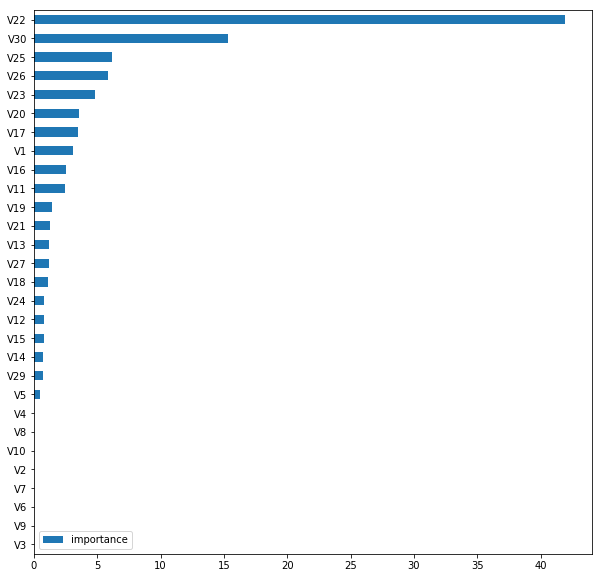

In [60]:
pd.DataFrame(rf.feature_importances_*100, index=x_v28.columns, 
             columns=['importance']).sort_values('importance', ascending=True).plot.barh(figsize = (10,10))

#### why the model results got better when I took out V28?

### correlation

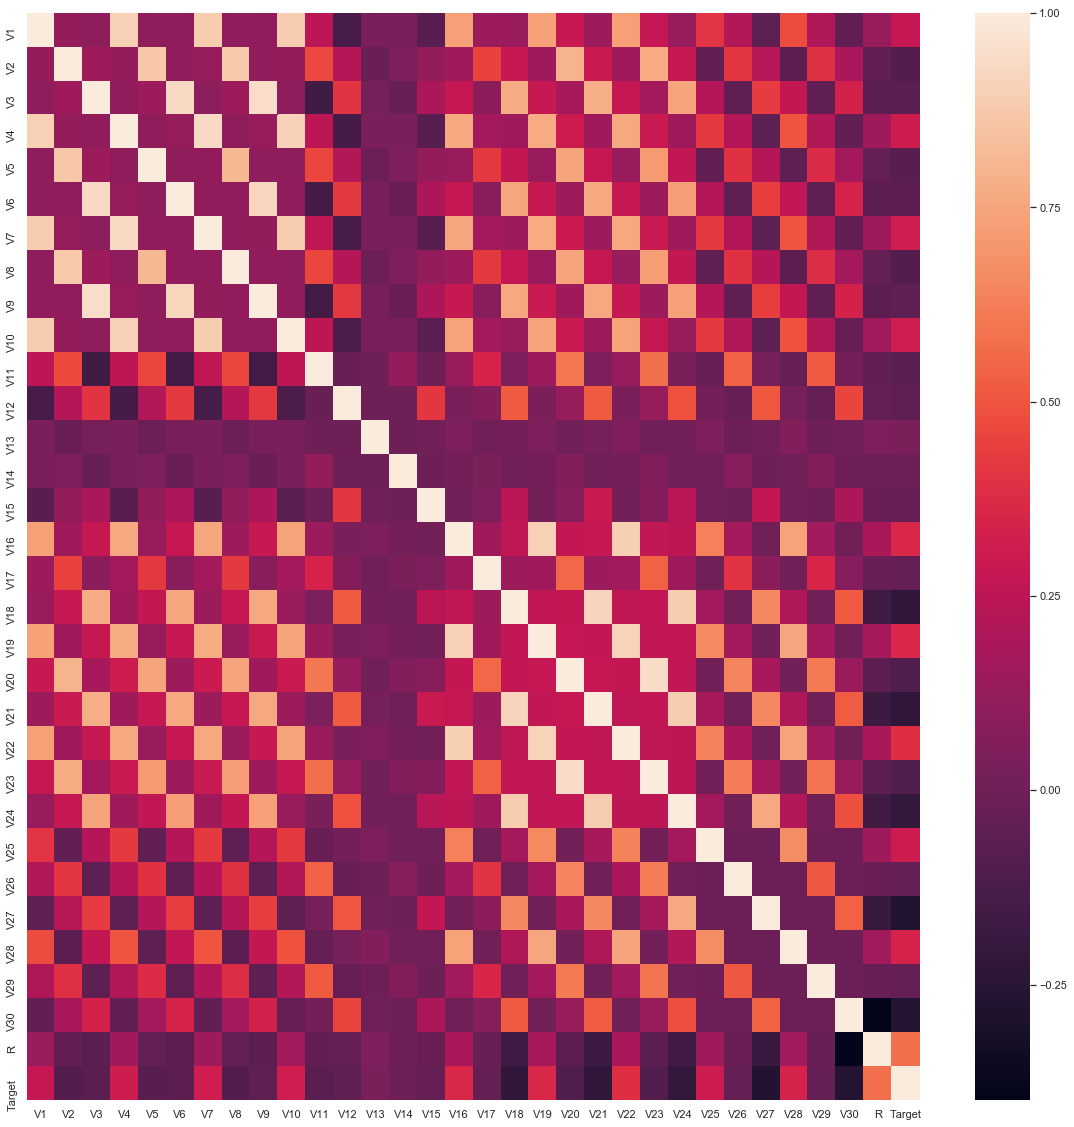

In [61]:
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(df.corr())

In [62]:
display_all(df.corr())

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,R,Target
V1,1.000000,0.120795,0.099686,0.901571,0.105794,0.107983,0.884398,0.106002,0.112181,0.887753,0.248615,-0.134792,0.034874,0.033536,-0.073034,0.727613,0.146492,0.139930,0.732726,0.288197,0.142985,0.727006,0.277886,0.134283,0.409042,0.213652,-0.057614,0.480836,0.205175,-0.041270,0.134034,0.273742
V2,0.120795,1.000000,0.151519,0.123796,0.868395,0.114735,0.125976,0.879316,0.114570,0.121020,0.471031,0.226304,-0.017597,0.044015,0.120276,0.153014,0.450262,0.289373,0.155316,0.793196,0.291581,0.153574,0.765353,0.281832,-0.048496,0.414113,0.234686,-0.063197,0.393382,0.182671,-0.042175,-0.097415
V3,0.099686,0.151519,1.000000,0.114626,0.142749,0.929368,0.103498,0.144389,0.947379,0.101004,-0.158606,0.403628,0.026864,-0.022071,0.187844,0.282359,0.094405,0.773506,0.287551,0.180083,0.777355,0.283831,0.174695,0.748598,0.227695,-0.051003,0.430935,0.268166,-0.049834,0.333942,-0.070594,-0.070375
V4,0.901571,0.123796,0.114626,1.000000,0.108200,0.127315,0.933622,0.107077,0.131669,0.904017,0.252333,-0.142599,0.035127,0.033908,-0.077826,0.755795,0.174372,0.157329,0.768542,0.300730,0.155907,0.762232,0.290230,0.150227,0.424069,0.222145,-0.056940,0.499013,0.214841,-0.043869,0.149970,0.306586
V5,0.105794,0.868395,0.142749,0.108200,1.000000,0.108983,0.110966,0.808927,0.107506,0.108247,0.461107,0.215739,-0.014078,0.045382,0.115420,0.135284,0.420347,0.271171,0.136523,0.747687,0.273459,0.135390,0.712916,0.263190,-0.048745,0.394082,0.218939,-0.058277,0.375017,0.171205,-0.035880,-0.080305
V6,0.107983,0.114735,0.929368,0.127315,0.108983,1.000000,0.112400,0.110911,0.920316,0.110309,-0.144546,0.422501,0.029182,-0.020037,0.198534,0.280631,0.076696,0.751031,0.286367,0.147004,0.755050,0.282103,0.143889,0.726681,0.225360,-0.057585,0.432841,0.265293,-0.055118,0.340420,-0.063311,-0.061729
V7,0.884398,0.125976,0.103498,0.933622,0.110966,0.112400,1.000000,0.113963,0.116289,0.889510,0.258091,-0.138694,0.035892,0.034470,-0.074634,0.749157,0.174756,0.146557,0.767808,0.300184,0.145399,0.755347,0.289809,0.149667,0.425318,0.222223,-0.059568,0.500535,0.214403,-0.045282,0.153760,0.313013
V8,0.106002,0.879316,0.144389,0.107077,0.808927,0.110911,0.113963,1.000000,0.110151,0.108252,0.461347,0.219779,-0.014972,0.044972,0.115673,0.143140,0.424416,0.277818,0.140020,0.748075,0.278150,0.134807,0.722836,0.268095,-0.052523,0.397562,0.221317,-0.062397,0.378018,0.174794,-0.037902,-0.095280
V9,0.112181,0.114570,0.947379,0.131669,0.107506,0.920316,0.116289,0.110151,1.000000,0.114233,-0.152267,0.420697,0.028573,-0.020121,0.196821,0.284946,0.079195,0.761606,0.290632,0.149085,0.763317,0.288069,0.144713,0.734961,0.228712,-0.052732,0.434814,0.269566,-0.057138,0.337303,-0.064662,-0.059439
V10,0.887753,0.121020,0.101004,0.904017,0.108247,0.110309,0.889510,0.108252,0.114233,1.000000,0.254917,-0.115460,0.036582,0.034759,-0.069998,0.742738,0.170922,0.140984,0.744973,0.292624,0.142753,0.740477,0.282336,0.134992,0.421217,0.217387,-0.057058,0.496439,0.217900,-0.032337,0.158827,0.316238


### RF without V28 and V25 () -- V22 is strongly correlated with V28 and moderately correlated with V25 
(model performance has decreased)

In [63]:
x_v28_v25 = df.drop(['R', 'Target', 'V28', 'V25'], axis=1)
y_v28_v25 = df['Target']

In [64]:
X_train_v28_v25, X_valid_v28_v25, y_train_v28_v25, y_valid_v28_v25 = train_test_split(x_v28_v25, y_v28_v25, stratify = y_v28_v25, test_size = 0.2, random_state = 42)

In [65]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=80, max_features=0.9, criterion='entropy', random_state = 123)
rf.fit(X_train_v28_v25, y_train_v28_v25)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [66]:
preds = rf.predict(X_valid_v28_v25)

In [67]:
accuracy_score(y_valid_v28_v25, preds)

0.98425

In [68]:
confusion_matrix(y_valid_v28_v25, preds)

array([[18773,   120],
       [  195,   912]], dtype=int64)

In [69]:
print(classification_report(y_valid_v28_v25, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18893
           1       0.88      0.82      0.85      1107

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.94      0.91      0.92     20000
weighted avg       0.98      0.98      0.98     20000



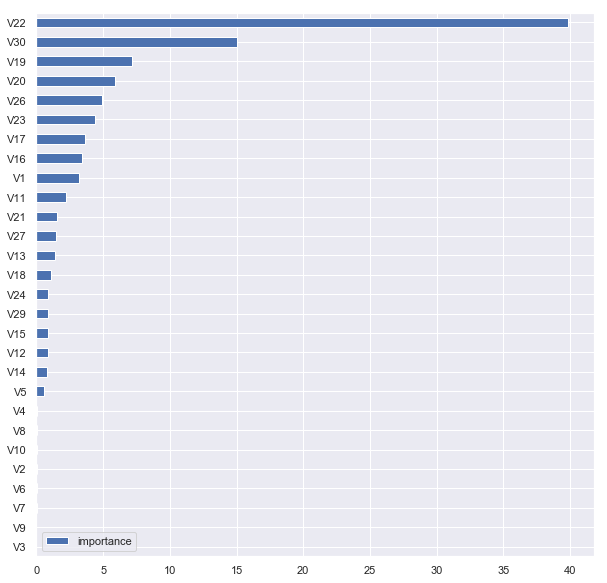

In [70]:
pd.DataFrame(rf.feature_importances_*100, index=x_v28_v25.columns, 
             columns=['importance']).sort_values('importance', ascending=True).plot.barh(figsize = (10,10))

### RF with variables having importance > 4% from the best model 
(model performance has somewhat decreased, but now model has less variables(plus point))

In [71]:
x_v_imp = df.drop(['R', 'Target', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V13', 'V14', 'V15',
                  'V18', 'V19', 'V21', 'V24', 'V27', 'V28', 'V29'], axis=1)
y_v_imp = df['Target']

In [72]:
X_train_v_imp, X_valid_v_imp, y_train_v_imp, y_valid_v_imp = train_test_split(x_v_imp, y_v_imp, stratify = y_v_imp, test_size = 0.2, random_state = 42)

In [73]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=80, max_features=0.9, criterion='entropy', random_state = 123)
rf.fit(X_train_v_imp, y_train_v_imp)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [74]:
preds = rf.predict(X_valid_v_imp)

In [75]:
accuracy_score(y_valid_v_imp, preds)

0.98405

In [76]:
confusion_matrix(y_valid_v_imp, preds)

array([[18768,   125],
       [  194,   913]], dtype=int64)

In [77]:
print(classification_report(y_valid_v_imp, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18893
           1       0.88      0.82      0.85      1107

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.93      0.91      0.92     20000
weighted avg       0.98      0.98      0.98     20000



In [59]:
print(classification_report(y_valid_v28, preds)) #best model results

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18893
           1       0.89      0.84      0.86      1107

   micro avg       0.99      0.99      0.99     20000
   macro avg       0.94      0.92      0.93     20000
weighted avg       0.98      0.99      0.99     20000



## Top 10 important variables

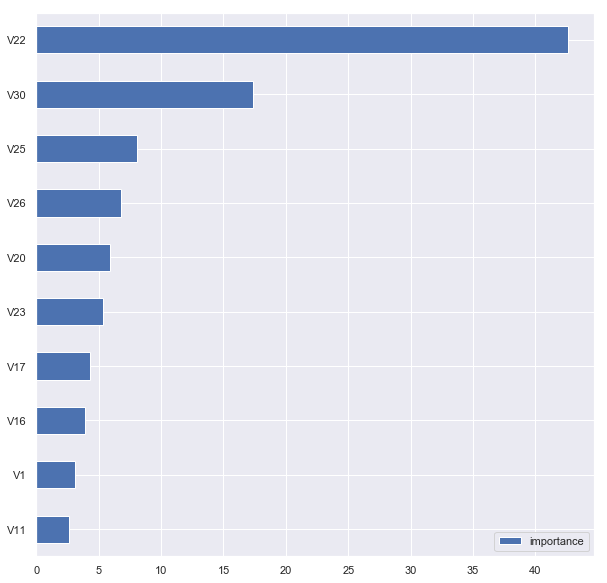

In [78]:
pd.DataFrame(rf.feature_importances_*100, index=x_v_imp.columns, 
             columns=['importance']).sort_values('importance', ascending=True).plot.barh(figsize = (10,10))

### checking multicollinearity 

In [79]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [80]:
x_vif = x.copy()

In [81]:
x_vif.shape

(100000, 30)

### threshold = 10

In [82]:
%time x_vif10 = calculate_vif_(x_vif, thresh=10)

dropping 'V3' at index: 2
dropping 'V4' at index: 2
dropping 'V20' at index: 17
dropping 'V9' at index: 6
dropping 'V2' at index: 1
Remaining variables:
Index(['V1', 'V5', 'V6', 'V7', 'V8', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15',
       'V16', 'V17', 'V18', 'V19', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26',
       'V27', 'V28', 'V29', 'V30'],
      dtype='object')
Wall time: 1min 13s


In [83]:
x_vif10.shape

(100000, 25)

### RF with vif = 10 (okish experiment)

In [84]:
X_train_vif10, X_valid_vif10, y_train_vif10, y_valid_vif10 = train_test_split(x_vif10, y, stratify = y, test_size = 0.2, random_state = 42)

In [85]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=80, max_features=0.9, criterion='entropy', random_state = 123)
rf.fit(X_train_vif10, y_train_vif10)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [86]:
preds = rf.predict(X_valid_vif10)

In [87]:
accuracy_score(y_valid_vif10, preds)

0.98465

In [88]:
confusion_matrix(y_valid_vif10, preds)

array([[18772,   121],
       [  186,   921]], dtype=int64)

In [89]:
print(classification_report(y_valid_vif10, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18893
           1       0.88      0.83      0.86      1107

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.94      0.91      0.92     20000
weighted avg       0.98      0.98      0.98     20000



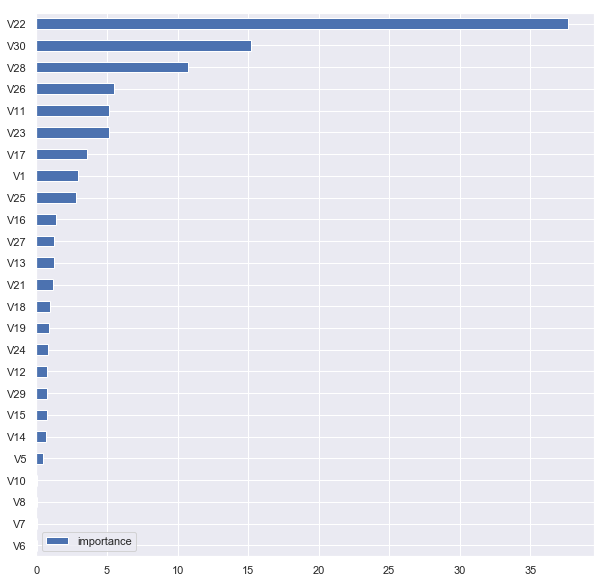

In [90]:
pd.DataFrame(rf.feature_importances_*100, index=x_vif10.columns, 
             columns=['importance']).sort_values('importance', ascending=True).plot.barh(figsize = (10,10))

# 22,30,25,26,23,20,17,1,16,11

### threshold = 5

In [91]:
%time x_vif5 = calculate_vif_(x_vif, thresh=5)

dropping 'V3' at index: 2
dropping 'V4' at index: 2
dropping 'V20' at index: 17
dropping 'V9' at index: 6
dropping 'V2' at index: 1
dropping 'V7' at index: 3
dropping 'V21' at index: 14
dropping 'V19' at index: 13
dropping 'V10' at index: 4
dropping 'V24' at index: 14
dropping 'V22' at index: 12
Remaining variables:
Index(['V1', 'V5', 'V6', 'V8', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17',
       'V18', 'V23', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30'],
      dtype='object')
Wall time: 1min 55s


In [92]:
x_vif5.shape

(100000, 19)

### RF with vif = 5 (failed experiment)

In [93]:
X_train_vif5, X_valid_vif5, y_train_vif5, y_valid_vif5 = train_test_split(x_vif5, y, stratify = y, test_size = 0.2, random_state = 42)

In [94]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=80, max_features=0.9, criterion='entropy', random_state = 123)
rf.fit(X_train_vif5, y_train_vif5)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [95]:
preds = rf.predict(X_valid_vif5)

In [96]:
accuracy_score(y_valid_vif5, preds)

0.97945

In [97]:
confusion_matrix(y_valid_vif5, preds)

array([[18758,   135],
       [  276,   831]], dtype=int64)

In [98]:
print(classification_report(y_valid_vif5, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18893
           1       0.86      0.75      0.80      1107

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.92      0.87      0.90     20000
weighted avg       0.98      0.98      0.98     20000



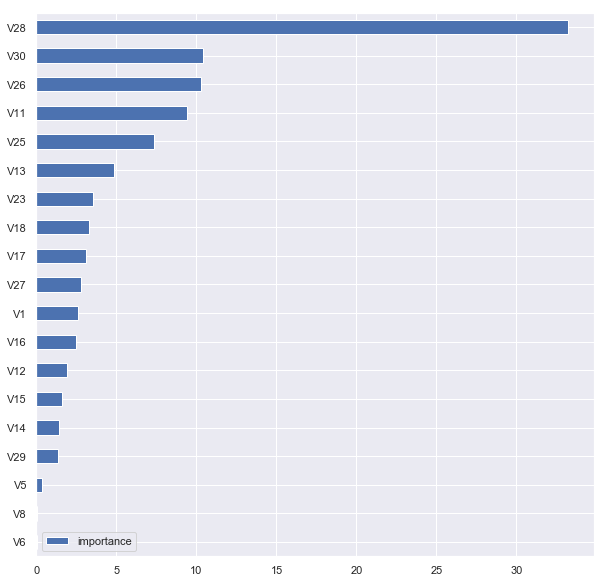

In [99]:
pd.DataFrame(rf.feature_importances_*100, index=x_vif5.columns, 
             columns=['importance']).sort_values('importance', ascending=True).plot.barh(figsize = (10,10))

In [100]:
# some of the variables are not normal (Tableau)
# df.to_csv(f"{path}case_study.csv", index = False)

### standardized these variables and ran the RF model (Top 10 variables)

In [351]:
x_stand = x[['V22','V30','V25','V26','V23','V20','V17','V16','V11','V1']]
x_stand['V11'] = np.log10(x_stand['V11']+5)
# x_v1 = x_stand['V1']
sc = StandardScaler()
x_stand[['V22','V30','V25','V26','V23','V20','V17','V16']] = sc.fit_transform(x_stand[['V22','V30','V25','V26','V23','V20','V17','V16']])
# x_stand['V11'] = x_v11
# x_stand['V1'] = x_v1

C:\Users\ps063n\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\ps063n\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\ps063n\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [352]:
x_stand.shape

(100000, 10)

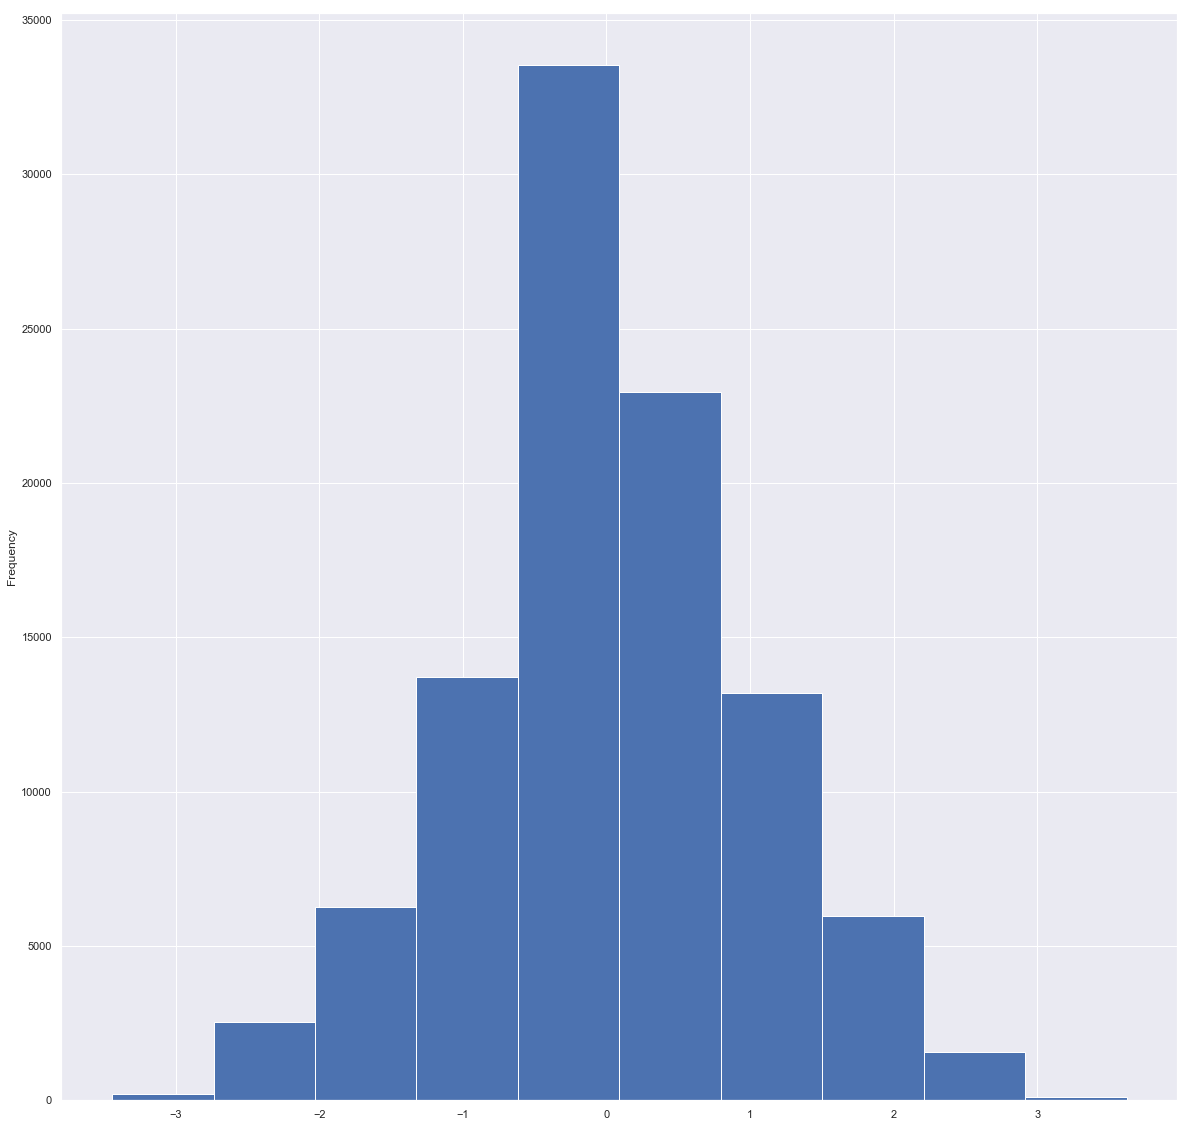

In [358]:
x_stand.iloc[:,0].plot.hist()

In [359]:
X_train_stand, X_valid_stand, y_train_stand, y_valid_stand = train_test_split(x_stand, y, stratify = y, test_size = 0.2, random_state = 42)

In [360]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=80, max_features=0.9, criterion='entropy', random_state = 123)
rf.fit(X_train_stand, y_train_stand)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [361]:
preds = rf.predict(X_valid_stand)

In [362]:
accuracy_score(y_valid_stand, preds)

0.9841

In [363]:
confusion_matrix(y_valid_stand, preds)

array([[18765,   128],
       [  190,   917]], dtype=int64)

In [364]:
print(classification_report(y_valid_stand, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18893
           1       0.88      0.83      0.85      1107

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.93      0.91      0.92     20000
weighted avg       0.98      0.98      0.98     20000



### By this time, I had my top 10 variables affecting the target (without oversampling)

### logistic regression

In [374]:
x_stand = x.copy()
sc = StandardScaler()
x_stand[['V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
            'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30']] = sc.fit_transform(x_stand[['V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
            'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30']])

In [375]:
x_stand.shape

(100000, 30)

In [376]:
X_train_stand, X_valid_stand, y_train_stand, y_valid_stand = train_test_split(x_stand, y, stratify = y, test_size = 0.2, random_state = 42)

In [377]:
logreg = LogisticRegression()
logreg.fit(X_train_stand, y_train_stand)

C:\Users\ps063n\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [378]:
preds = logreg.predict(X_valid_stand)

In [379]:
accuracy_score(y_valid_stand, preds)

0.9755

In [380]:
confusion_matrix(y_valid_stand, preds)

array([[18772,   121],
       [  369,   738]], dtype=int64)

In [381]:
print(classification_report(y_valid_stand, preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     18893
           1       0.86      0.67      0.75      1107

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.92      0.83      0.87     20000
weighted avg       0.97      0.98      0.97     20000



### xgboost classification model

In [382]:
X_train, X_valid, y_train, y_valid = train_test_split(x,y, stratify = y, test_size = 0.2, random_state = 42)

In [474]:
gb_model = xgb.XGBClassifier(n_estimators= 100, colsample_bytree=0.7, max_depth= 5, learning_rate=0.3, random_state = 123)

In [475]:
gb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [476]:
preds = gb_model.predict(X_valid)

In [477]:
accuracy_score(y_valid, preds)

0.9836

In [478]:
confusion_matrix(y_valid, preds)

array([[18780,   113],
       [  215,   892]], dtype=int64)

In [479]:
print(classification_report(y_valid, preds)) #not better than RF

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18893
           1       0.89      0.81      0.84      1107

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.94      0.90      0.92     20000
weighted avg       0.98      0.98      0.98     20000



## updated target variable - High valued customers (R >= 50)

In [134]:
df_updated = df.copy()

In [135]:
df_updated.drop('Target', axis=1, inplace=True)

In [137]:
df_updated.R.describe()

count    100000.000000
mean          2.115001
std          15.225975
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         945.037446
Name: R, dtype: float64

In [138]:
df_updated['Target_binned'] = np.where(df_updated.R >= 50, 1, 0)

In [139]:
df_updated.Target_binned.value_counts()

0    98820
1     1180
Name: Target_binned, dtype: int64

In [140]:
df_updated.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,V29,V30,R,Target_binned
0,1.0,1,0,1,1.0,0,1,1.0,0,1,...,1.332046,-0.383623,58.203268,2.516582,-0.063320,47.187762,0.050729,-3.556211,0.0,0
1,0.0,1,1,0,1.0,1,0,1.0,1,0,...,1.732377,4.118886,0.029545,3.469034,61.629681,0.058782,56.154209,11.777673,0.0,0
2,0.0,1,1,0,1.0,1,0,0.0,1,0,...,4.083644,2.500723,0.285155,31.284113,47.512823,0.101458,35.196478,81.645561,0.0,0
3,0.0,0,0,0,0.0,0,0,0.0,0,0,...,-1.545734,-2.284548,-200.012461,-0.046499,-19.956440,-0.030863,-4.907402,-4.157230,0.0,0
4,0.0,0,1,0,0.0,1,1,0.0,1,0,...,-0.769063,1.164243,3.792408,-0.003194,10.892589,0.547955,-0.017424,3.889439,0.0,0


In [141]:
x_updated = df_updated.drop(['R', 'Target_binned'], axis=1)
y_updated = df_updated['Target_binned']

In [142]:
X_train_updated, X_valid_updated, y_train_updated, y_valid_updated = train_test_split(x_updated, y_updated, stratify = y_updated, test_size = 0.2, random_state = 42)

In [154]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features=0.9, criterion='entropy', random_state = 123)
rf.fit(X_train_updated, y_train_updated)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [155]:
preds = rf.predict(X_valid_updated)

In [156]:
accuracy_score(y_valid_updated, preds)

0.9937

In [157]:
confusion_matrix(y_valid_updated, preds)

array([[19734,    30],
       [   96,   140]], dtype=int64)

In [158]:
print(classification_report(y_valid_updated, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19764
           1       0.82      0.59      0.69       236

   micro avg       0.99      0.99      0.99     20000
   macro avg       0.91      0.80      0.84     20000
weighted avg       0.99      0.99      0.99     20000



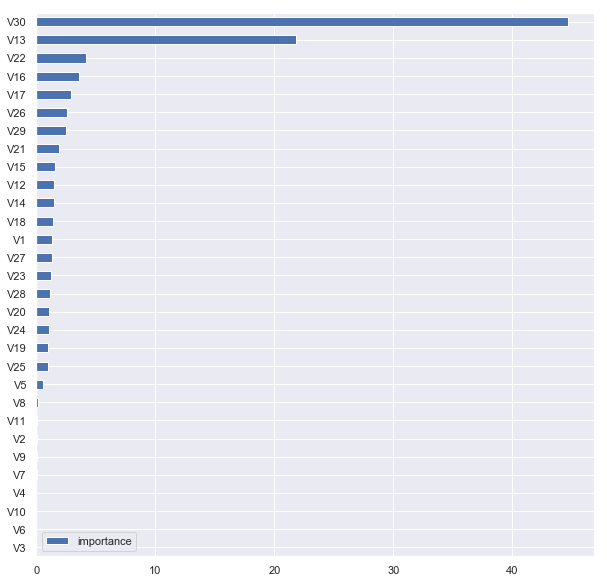

In [159]:
pd.DataFrame(rf.feature_importances_*100, index=x_updated.columns, 
             columns=['importance']).sort_values('importance', ascending=True).plot.barh(figsize = (10,10))

# handling rare events

In [171]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 42)

In [172]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 4428
Before OverSampling, counts of label '0': 75572 

After OverSampling, the shape of train_X: (151144, 30)
After OverSampling, the shape of train_y: (151144,) 

After OverSampling, counts of label '1': 75572
After OverSampling, counts of label '0': 75572


In [205]:
os_data_X = pd.DataFrame(data=X_train_res, columns=X_train.columns)
os_data_y= pd.DataFrame(data=y_train_res, columns=['Target'])

### RF with SMOTE

In [187]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features=0.5, criterion='entropy', random_state = 123)
rf.fit(os_data_X, os_data_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [188]:
preds = rf.predict(X_valid)

In [189]:
accuracy_score(y_valid, preds)

0.98125

In [190]:
confusion_matrix(y_valid, preds)

array([[18620,   273],
       [  102,  1005]], dtype=int64)

In [191]:
print(classification_report(y_valid, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18893
           1       0.79      0.91      0.84      1107

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.89      0.95      0.92     20000
weighted avg       0.98      0.98      0.98     20000



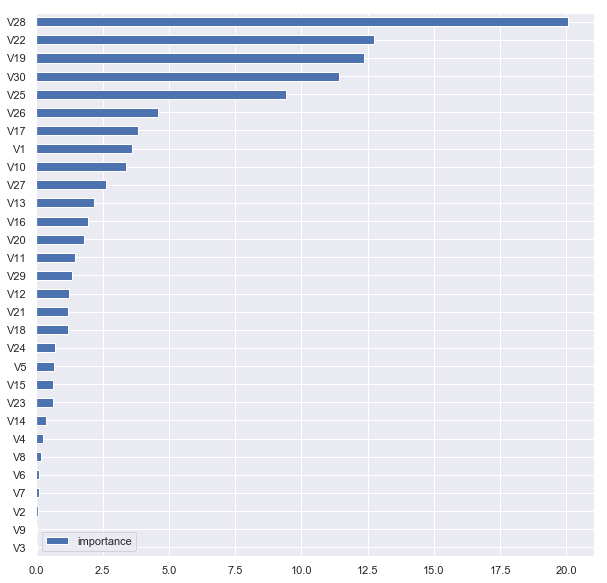

In [195]:
pd.DataFrame(rf.feature_importances_*100, index=X_train.columns, 
             columns=['importance']).sort_values('importance', ascending=True).plot.barh(figsize = (10,10))

### RF with SMOTE without V28 (better model)

In [222]:
os_data_X_v28 = os_data_X.drop(['V28'], axis=1)

In [213]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features=0.5, criterion='entropy', random_state = 123)
rf.fit(os_data_X_v28, os_data_y)

C:\Users\ps063n\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [215]:
os_data_X_valid_v28 = X_valid.drop('V28', axis=1)

In [216]:
preds = rf.predict(os_data_X_valid_v28)

In [217]:
accuracy_score(y_valid, preds)

0.9824

In [218]:
confusion_matrix(y_valid, preds)

array([[18630,   263],
       [   89,  1018]], dtype=int64)

In [219]:
print(classification_report(y_valid, preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     18893
           1       0.79      0.92      0.85      1107

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.89      0.95      0.92     20000
weighted avg       0.98      0.98      0.98     20000



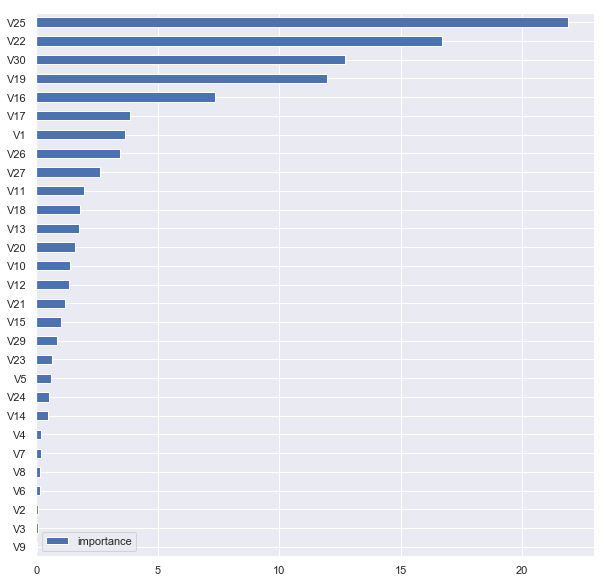

In [220]:
pd.DataFrame(rf.feature_importances_*100, index=os_data_X_v28.columns, 
             columns=['importance']).sort_values('importance', ascending=True).plot.barh(figsize = (10,10))

### RF with variables having importance > 4% from the best model

In [243]:
x_v_imp = os_data_X.drop(['V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V13', 'V14', 'V15',
                  'V18', 'V20', 'V21', 'V23', 'V24', 'V28', 'V29'], axis=1)
y_v_imp = os_data_y

In [244]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=80, max_features=0.9, criterion='entropy', random_state = 123)
rf.fit(x_v_imp, y_v_imp)

C:\Users\ps063n\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [245]:
x_valid_imp = X_valid.drop(['V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V13', 'V14', 'V15',
                  'V18', 'V20', 'V21', 'V23', 'V24', 'V28', 'V29'], axis=1)

In [246]:
preds = rf.predict(x_valid_imp)

In [247]:
accuracy_score(y_valid, preds)

0.97855

In [248]:
confusion_matrix(y_valid, preds)

array([[18544,   349],
       [   80,  1027]], dtype=int64)

In [249]:
print(classification_report(y_valid, preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     18893
           1       0.75      0.93      0.83      1107

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.87      0.95      0.91     20000
weighted avg       0.98      0.98      0.98     20000



## Top 10 important variables (after SMOTE)

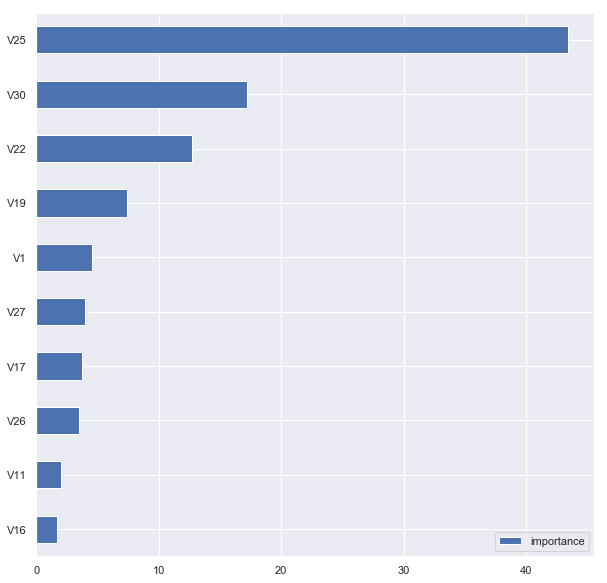

In [250]:
pd.DataFrame(rf.feature_importances_*100, index=x_v_imp.columns, 
             columns=['importance']).sort_values('importance', ascending=True).plot.barh(figsize = (10,10))

before smote = V22,V30,V25,V26,V11,V16,V17,V1,V20,V23
after smote = V22,V30,V25,V26,V11,V16,V17,V1,V27,V19ey

sa## logistic with SMOTE (poor model)

In [203]:
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

C:\Users\ps063n\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ps063n\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ps063n\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ps063n\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ps063n\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

[ True  True  True  True  True  True  True  True  True  True  True False
 False False False  True  True  True  True  True  True  True  True  True
 False False False False False False]
[ 1  1  1  1  1  1  1  1  1  1  1  2 11 10  7  1  1  1  1  1  1  1  1  1
  5  6  8  4  9  3]


In [206]:
X_train.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30'],
      dtype='object')

In [209]:
cols=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V30'] 
X=os_data_X[cols]
y=os_data_y['Target']

In [210]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.184668
         Iterations 9
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.734      
Dependent Variable: Target           AIC:              55862.9263 
Date:               2019-04-12 13:15 BIC:              56061.4461 
No. Observations:   151144           Log-Likelihood:   -27911.    
Df Model:           19               LL-Null:          -1.0477e+05
Df Residuals:       151124           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     9.0000                                        
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
V1        -3.2460     0.0555   -58.4357   0.0000   -3.3549   -3.1371
V2        -1.6915     0.0624   -27.1209   0.0

In [194]:
lr1 = LogisticRegression(C=3,penalty='l1', verbose=2)
lr1.fit(X_train_res, y_train_res.ravel())

C:\Users\ps063n\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=2, warm_start=False)

In [197]:
preds = lr1.predict(X_valid)

In [198]:
accuracy_score(y_valid, preds)

0.9404

In [199]:
confusion_matrix(y_valid, preds)

array([[17757,  1136],
       [   56,  1051]], dtype=int64)

In [200]:
print(classification_report(y_valid, preds))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     18893
           1       0.48      0.95      0.64      1107

   micro avg       0.94      0.94      0.94     20000
   macro avg       0.74      0.94      0.80     20000
weighted avg       0.97      0.94      0.95     20000



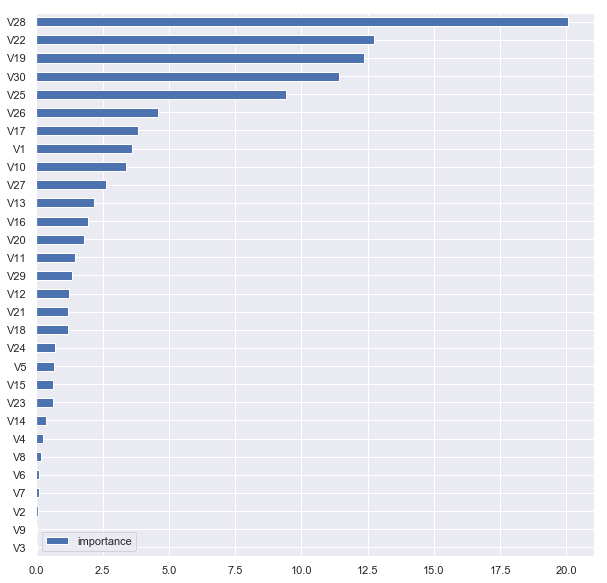

In [195]:
pd.DataFrame(rf.feature_importances_*100, index=X_train.columns, 
             columns=['importance']).sort_values('importance', ascending=True).plot.barh(figsize = (10,10))

## Final results

In [259]:
x_final = x[['V22','V30','V25','V26','V11','V16','V17','V1','V20','V23','V27','V19']]
y_final = df['Target']

In [260]:
X_train_final, X_valid_final, y_train_final, y_valid_final = train_test_split(x_final, y_final, stratify = y_final, test_size = 0.2, random_state = 42)

In [261]:
logit_model=sm.Logit(y_final,x_final)
result=logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.253057
         Iterations 11
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.183    
Dependent Variable: Target           AIC:              50635.4567
Date:               2019-04-12 14:54 BIC:              50749.6118
No. Observations:   100000           Log-Likelihood:   -25306.   
Df Model:           11               LL-Null:          -21398.   
Df Residuals:       99988            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     11.0000                                      
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
V22       0.5846     0.0129    45.2916   0.0000    0.5593    0.6099
V30      -0.0022     0.0001   -27.4781   0.0000   -0.0024

### Also, ran a logistic regression model in SAS Enterprise Miner to get the odds ratio of the variables in order to explain the results to the business